# Algorithm Testing

In [1]:
from scrapers import logger
from collections import OrderedDict
from Truth import Page
import csv

logger.ignorewarnings = True

metric = []
ultrametric = []
metric_tfidf = []
ultrametric_tfidf = []

STOP_UNTIL = 500

**1. Get a path matrix from a CSV File.**

This will ensure that the pages have their corresponding backlinks and page content in the database. The code below will transform the pathstrings into a list of traversed <Page> objects.

In [2]:
pathlist = []

with open('data/out/i1.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';', quotechar='"')
    processed_count = 0
    pathlist = list(reader)

In [24]:
for row in pathlist:

    # limit the number of things to process
    if processed_count >STOP_UNTIL:
        break
    processed_count+=1

    # These dictioanries contain the truth values in different aglorithms.
    # the keys are the ideology names in the csv file.
    # use key 'x-entity' to get hte x axis.
    row_metric = OrderedDict()
    row_ultrametric = OrderedDict()
    row_metric_tfidf = OrderedDict()
    row_ultrametric_tfidf = OrderedDict()


    for key in row.keys():
        row[key] = row[key].split('>')
        for idx, title in enumerate(row[key]):
            if idx!=0 and idx != len(row[key])-1:
                Page(title, backlinksonly=True)

## Create Lemmatization Methods

In [27]:
import nltk, string, numpy
nltk.download('wordnet') # first-time use only
lemmer = nltk.stem.WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmer.lemmatize(token) for token in tokens]
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

def normalizenumber(num, sta, mx, normarange):
    nom = (num-sta)/(mx-sta)
    return nom* normarange

normalizenumber(10, 0, 100, 10)
    

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Leryc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1.0

## Calculate the truth values.
### Standard Metric Closure with TFIDF

In [3]:
import sys
processed_count = 0
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import math
import pandas as pd

def idf(n,df):
            result = math.log((n+1.0)/(df+1.0)) + 1
            return result
        
import pandas as pd

metric_tfidf = pd.DataFrame( columns= list(pathlist[0].keys())[1:])
metric = pd.DataFrame( columns= list(pathlist[0].keys())[1:])


print(metric_tfidf)
keys = pathlist[0].keys()
for row in pathlist:
    # limit the number of things to process
    if processed_count>STOP_UNTIL:
        break
    processed_count+=1
    
    # the metrics
    row_metric = []
    row_metric_without_tfidf = []
    
    for x in list(row.keys())[1:]:# do not include row header
        
        path = [Page(d) for d in row[x]]
        
        source = path[0] # get the first element of the path
        dest = path[len(path)-1] # get the last element of the path
        
        
        # SKLEARN PARTS
        # Turn text into vectors of term frequency:
        documents = [source.pagecontent, dest.pagecontent]
        
        
        TfidfVec = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english')
        def cos_similarity(textlist):
            tfidf = TfidfVec.fit_transform(textlist)
            return (tfidf * tfidf.T).toarray()
        cos_sim = cos_similarity(documents)
        
        # normalize the cosine similarity to 0.25 range.
        cos_sim = normalizenumber(cos_sim[0][1], 0, 0.25, 1)
        
        truthvalue = 1.00
        truthvalue_withouttfidf = 1.00
        for x in path[1:]:
            truthvalue+=(normalizenumber(x.backlinkcount, 0, 500000, 200))*(cos_sim**(1/2))
            truthvalue_withouttfidf += (normalizenumber(x.backlinkcount, 0, 500000, 200))
            
        truthvalue = 1/truthvalue
        truthvalue_withouttfidf = 1/ truthvalue_withouttfidf
        #print(f"{source.title} -> {dest.title} = {truthvalue}")
        
        
        row_metric.append(truthvalue)
        row_metric_without_tfidf.append(truthvalue_withouttfidf)
        
    df2 = pd.DataFrame([row_metric], columns=list(row.keys())[1:])
    df2_withouttfidf = pd.DataFrame([row_metric_without_tfidf], columns=list(row.keys())[1:])
    
    metric = metric.append(df2_withouttfidf, ignore_index=True)
    metric_tfidf = metric_tfidf.append(df2, ignore_index=True)
    print(str(processed_count)+"/"+str(len(pathlist)))
# TODO: append data to dataframe***

metric_tfidf.to_csv('metric_tfidf.csv', sep=';')
metric.to_csv('metric_standard.csv', sep=';')
metric

    

Empty DataFrame
Columns: [Anarchism, Antisemitism, Capitalism, Christianity, Communism, Conservatism, Democracy, Fascism, Feminism, Islamophobia, Left-wing politics, Liberalism, Marxism, Nationalism, Neo-Nazism, Protestantism, Right-wing politics, Secularism, Socialism, White supremacy]
Index: []


PageError: Page id " " does not match any pages. Try another id!

## Append politician names and target values
The dataframe only consists of truth values and does not include the target and the politician. Label them according to the original path csv file.

In [ ]:
full_csv = pd.read_csv('data/out/i1.csv', sep=';')
try:
    metric_tfidf.insert(0, 'politician', full_csv['x-entity'])
except ValueError:
    pass # the column already exists

Include the target (Republican or Democrat)

In [ ]:
def getAffiliation(politician):
    if politician.endswith('(R)'):
        return "Republican"
    else:
        return "Democrat"
        
targetcol = [getAffiliation(x) for x in list(full_csv['x-entity'])]
targetcol = pd.Series(targetcol, name="target")

metric_tfidf['target'] = targetcol
print(metric_tfidf[:10])



## Save data to CSV

In [ ]:
metric_tfidf.to_csv('metric_squared.csv', sep=';')
metric_tfidf

## Load existing data from CSV

In [30]:
# RUN This when loading from a CSV. Otherwise dont run.
import pandas as pd
metric_tfidf = pd.read_csv('saved_csvs/hdf.csv', sep=';')
metric_tfidf = metric_tfidf.drop(metric_tfidf.columns[0], axis=1)
metric_tfidf[:3]

metric = pd.read_csv('saved_csvs/metric_standard.csv', sep=';')
metric = metric.drop(metric.columns[0], axis=1)
metric[:3]

,politician,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,...,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy,target
0,Jo Bonner (R),0.146722,0.091609,0.180479,0.021633,0.097656,0.031023,0.045220,0.034661,0.043991,...,0.078069,0.117421,0.132514,0.241896,0.013566,0.036427,0.094066,0.072632,0.212062,Republican
1,Martha Roby (R),0.033260,0.042244,0.046237,0.021633,0.071264,0.031023,0.045220,0.034661,0.043991,...,0.046106,0.019858,0.010873,0.053905,0.030753,0.036427,0.051254,0.017983,0.054233,Republican
2,Mike Rogers (R),0.021361,0.015905,0.091868,0.021516,0.067148,0.030784,0.028469,0.034363,0.063251,...,0.079620,0.075533,0.012779,0.015556,0.013617,0.036098,0.007482,0.059669,0.112613,Republican


## WITHOUT TFIDF STANDARD

In [26]:
import sys
processed_count = 0
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import math
import pandas as pd

def idf(n,df):
            result = math.log((n+1.0)/(df+1.0)) + 1
            return result
        
import pandas as pd


metric = pd.DataFrame( columns= list(pathlist[0].keys())[1:])


print(metric_tfidf)
keys = pathlist[0].keys()
for row in pathlist:
    # limit the number of things to process
    if processed_count>STOP_UNTIL:
        break
    processed_count+=1
    
    # the metrics
    row_metric_without_tfidf = []
    
    for x in list(row.keys())[1:]:# do not include row header
        
        path = [Page(d) for d in row[x]]
        
        source = path[0] # get the first element of the path
        dest = path[len(path)-1] # get the last element of the path      

        truthvalue_withouttfidf = 1.00
        for x in path[1:]:
            truthvalue_withouttfidf += (normalizenumber(x.backlinkcount, 0, 500000, 200))
            
        truthvalue_withouttfidf = 1/ truthvalue_withouttfidf
        #print(f"{source.title} -> {dest.title} = {truthvalue}")
        
        row_metric_without_tfidf.append(truthvalue_withouttfidf)
        
    df2_withouttfidf = pd.DataFrame([row_metric_without_tfidf], columns=list(row.keys())[1:])
    
    metric = metric.append(df2_withouttfidf, ignore_index=True)
    print(str(processed_count)+"/"+str(len(pathlist)))
# TODO: append data to dataframe***

metric.to_csv('metric_standard.csv', sep=';')
metric

    

[]


NameError: name 'normalizenumber' is not defined

In [11]:
full_csv = pd.read_csv('data/out/i1.csv', sep=';')
try:
    metric.insert(0, 'politician', full_csv['x-entity'])
except ValueError:
    pass # the column already exists

def getAffiliation(politician):
    if politician.endswith('(R)'):
        return "Republican"
    else:
        return "Democrat"
        
targetcol = [getAffiliation(x) for x in list(full_csv['x-entity'])]
targetcol = pd.Series(targetcol, name="target")
metric['target'] = targetcol


metric.to_csv('metric_standard.csv', sep=';')
metric[:10]

,politician,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,...,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy,target
0,Jo Bonner (R),0.389793,0.282265,0.570395,0.103724,0.311893,0.085618,0.143317,0.117690,0.237937,...,0.289348,0.444209,0.403089,0.406166,0.053445,0.117850,0.383268,0.193979,0.624274,Republican
1,Martha Roby (R),0.087244,0.118787,0.126976,0.098863,0.181479,0.053402,0.087501,0.087497,0.127577,...,0.101852,0.071169,0.032949,0.096031,0.095543,0.074964,0.141558,0.032312,0.147651,Republican
2,Mike Rogers (R),0.057858,0.048418,0.309324,0.097155,0.218835,0.116308,0.118370,0.088986,0.306504,...,0.223929,0.324011,0.032299,0.027253,0.049886,0.138746,0.035476,0.148497,0.367861,Republican
3,Robert Aderholt (R),0.319432,0.087385,0.105486,0.061038,0.212148,0.152969,0.085595,0.066291,0.138963,...,0.080587,0.059242,0.022340,0.444131,0.065132,0.058660,0.120104,0.026982,0.105902,Republican
4,Mo Brooks (R),0.329190,0.035869,0.105148,0.059093,0.074919,0.044554,0.204169,0.082491,0.150685,...,0.085840,0.060440,0.092678,0.068416,0.069027,0.067313,0.145345,0.025803,0.094864,Republican
5,Spencer Bachus (R),0.244368,0.242502,0.046157,0.072517,0.223289,0.052352,0.054428,0.060701,0.192810,...,0.369900,0.072314,0.071051,0.119647,0.128444,0.078237,0.079688,0.056602,0.222181,Republican
6,Terri Sewell (D),0.061189,0.100751,0.120191,0.061327,0.141132,0.049367,0.075185,0.049308,0.077355,...,0.086347,0.061806,0.027417,0.072814,0.065366,0.060017,0.135169,0.030517,0.632686,Democrat
7,Paul Gosar (R),0.146574,0.039618,0.187964,0.048789,0.057191,0.061409,0.145892,0.072664,0.154155,...,0.078502,0.386360,0.109016,0.089585,0.035743,0.072785,0.076144,0.050558,0.127546,Republican
8,Trent Franks (R),0.273791,0.217991,0.187396,0.037288,0.057284,0.064042,0.135372,0.077579,0.240469,...,0.090917,0.204867,0.115260,0.093619,0.028735,0.375560,0.071129,0.080384,0.343281,Republican
9,Ben Quayle (R),0.118009,0.111062,0.175068,0.096077,0.054850,0.053966,0.141790,0.068638,0.312648,...,0.074536,0.202203,0.109210,0.088221,0.030343,0.092571,0.089880,0.101289,0.148290,Republican


## Classification Task
### Metric with TFIDF

In [31]:
metric_tfidf.keys()

Index(['politician', 'Anarchism', 'Antisemitism', 'Capitalism', 'Christianity',
       'Communism', 'Conservatism', 'Democracy', 'Fascism', 'Feminism',
       'Islamophobia', 'Left-wing politics', 'Liberalism', 'Marxism',
       'Nationalism', 'Neo-Nazism', 'Protestantism', 'Right-wing politics',
       'Secularism', 'Socialism', 'White supremacy', 'target'],
      dtype='object')

**Drop politican and target labels and split to X and y**

In [32]:
X = metric_tfidf.drop('politician', axis=1)
y = metric_tfidf['target'] == "Democrat"
X = X.drop('target', axis=1)
X[:10]

,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,Islamophobia,Left-wing politics,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy
0,0.389793,0.282265,0.570395,0.103724,0.311893,0.085618,0.143317,0.117690,0.237937,0.474123,0.221616,0.289348,0.444209,0.403089,0.406166,0.053445,0.117850,0.383268,0.193979,0.624274
1,0.087244,0.118787,0.126976,0.098863,0.181479,0.053402,0.087501,0.087497,0.127577,0.180382,0.024179,0.101852,0.071169,0.032949,0.096031,0.095543,0.074964,0.141558,0.032312,0.147651
2,0.057858,0.048418,0.309324,0.097155,0.218835,0.116308,0.118370,0.088986,0.306504,0.145596,0.037848,0.223929,0.324011,0.032299,0.027253,0.049886,0.138746,0.035476,0.148497,0.367861
3,0.319432,0.087385,0.105486,0.061038,0.212148,0.152969,0.085595,0.066291,0.138963,0.151472,0.018180,0.080587,0.059242,0.022340,0.444131,0.065132,0.058660,0.120104,0.026982,0.105902
4,0.329190,0.035869,0.105148,0.059093,0.074919,0.044554,0.204169,0.082491,0.150685,0.160691,0.018960,0.085840,0.060440,0.092678,0.068416,0.069027,0.067313,0.145345,0.025803,0.094864
5,0.244368,0.242502,0.046157,0.072517,0.223289,0.052352,0.054428,0.060701,0.192810,0.257647,0.162954,0.369900,0.072314,0.071051,0.119647,0.128444,0.078237,0.079688,0.056602,0.222181
6,0.061189,0.100751,0.120191,0.061327,0.141132,0.049367,0.075185,0.049308,0.077355,0.173784,0.022359,0.086347,0.061806,0.027417,0.072814,0.065366,0.060017,0.135169,0.030517,0.632686
7,0.146574,0.039618,0.187964,0.048789,0.057191,0.061409,0.145892,0.072664,0.154155,0.149016,0.095244,0.078502,0.386360,0.109016,0.089585,0.035743,0.072785,0.076144,0.050558,0.127546
8,0.273791,0.217991,0.187396,0.037288,0.057284,0.064042,0.135372,0.077579,0.240469,0.323638,0.083563,0.090917,0.204867,0.115260,0.093619,0.028735,0.375560,0.071129,0.080384,0.343281
9,0.118009,0.111062,0.175068,0.096077,0.054850,0.053966,0.141790,0.068638,0.312648,0.173588,0.094882,0.074536,0.202203,0.109210,0.088221,0.030343,0.092571,0.089880,0.101289,0.148290


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

forest_clf = RandomForestClassifier()
score_standard = cross_val_score(forest_clf, X, y, cv=5)

print("Scores: {}".format(score_standard))
print("Average score: {:.3f}".format(score_standard.mean()))

Scores: [0.55       0.63157895 0.57894737 0.73684211 0.55555556]
Average score: 0.611


In [34]:
from sklearn.svm import LinearSVC
import numpy as np
svm_clf = LinearSVC(C=2**7, loss="hinge")

from sklearn.model_selection import cross_val_score 
scores = cross_val_score(svm_clf,X,y,cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.60


### Metric Without TFIDF

In [35]:
Xw = metric.drop('politician', axis=1)
yw = metric['target']=="Democrat"# democrat = 1
Xw = Xw.drop('target', axis=1)
Xw[:10]

,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,Islamophobia,Left-wing politics,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy
0,0.146722,0.091609,0.180479,0.021633,0.097656,0.031023,0.045220,0.034661,0.043991,0.173310,0.079735,0.078069,0.117421,0.132514,0.241896,0.013566,0.036427,0.094066,0.072632,0.212062
1,0.033260,0.042244,0.046237,0.021633,0.071264,0.031023,0.045220,0.034661,0.043991,0.053978,0.010871,0.046106,0.019858,0.010873,0.053905,0.030753,0.036427,0.051254,0.017983,0.054233
2,0.021361,0.015905,0.091868,0.021516,0.067148,0.030784,0.028469,0.034363,0.063251,0.029742,0.012776,0.079620,0.075533,0.012779,0.015556,0.013617,0.036098,0.007482,0.059669,0.112613
3,0.192012,0.042244,0.046237,0.021633,0.110302,0.114082,0.045220,0.034661,0.043991,0.053978,0.010871,0.046106,0.019858,0.010873,0.372412,0.030753,0.036427,0.051254,0.017983,0.054233
4,0.184816,0.015909,0.045582,0.021633,0.038367,0.031023,0.107195,0.045450,0.043991,0.053978,0.010871,0.046106,0.019858,0.046063,0.053905,0.030753,0.036427,0.051254,0.017983,0.049870
5,0.146722,0.130019,0.022288,0.021633,0.104993,0.031023,0.024052,0.034661,0.062299,0.093158,0.088797,0.218036,0.021926,0.035380,0.104275,0.054243,0.036427,0.025658,0.040230,0.088280
6,0.030716,0.042244,0.046237,0.021633,0.061375,0.021759,0.045220,0.023488,0.043991,0.053978,0.010871,0.046106,0.019858,0.010873,0.053905,0.030753,0.024286,0.051254,0.017983,0.360490
7,0.064416,0.015909,0.062361,0.013705,0.020417,0.031023,0.063544,0.034661,0.041158,0.049190,0.047986,0.038737,0.138206,0.051408,0.069204,0.011941,0.036427,0.023400,0.027648,0.056196
8,0.146722,0.125219,0.062361,0.013705,0.020417,0.031023,0.063544,0.034661,0.086875,0.161457,0.047986,0.038737,0.059687,0.051408,0.069204,0.011941,0.207831,0.023400,0.046742,0.158418
9,0.064416,0.049782,0.062361,0.029063,0.020417,0.031023,0.063544,0.034661,0.113760,0.049190,0.047986,0.038737,0.059687,0.051408,0.069204,0.011941,0.036427,0.023400,0.057815,0.056196


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

forest_clfw = RandomForestClassifier()
score_standardw = cross_val_score(forest_clfw, Xw, yw, cv=5)

print("Scores: {}".format(score_standardw))
print("Average score: {:.3f}".format(score_standardw.mean()))

Scores: [0.65       0.73684211 0.73684211 0.63157895 0.55555556]
Average score: 0.662


In [37]:
from sklearn.svm import LinearSVC
import numpy as np
svm_clfw = LinearSVC(C=2**7, loss="hinge")

from sklearn.model_selection import cross_val_score 
scoresw = cross_val_score(svm_clfw,Xw,yw,cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scoresw)))

Mean cross-validation accuracy: 0.50


## Charts n stuff
**Without TFIDF/Cosine Similarity**

             precision    recall  f1-score   support

      False  0.4878048780 0.4347826087 0.4597701149        46
       True  0.5185185185 0.5714285714 0.5436893204        49

avg / total  0.5036466505 0.5052631579 0.5030547578        95



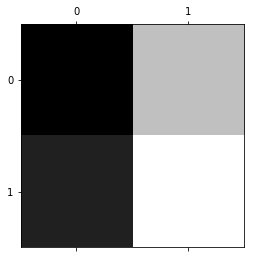

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
ywpred = cross_val_predict(svm_clfw, Xw, yw, cv=5)
print(classification_report(yw, ywpred, digits=10))
conf_mxw = confusion_matrix(yw, ywpred)
plt.matshow(conf_mxw,cmap=plt.cm.gray)
plt.show()

             precision    recall  f1-score   support

      False  0.5777777778 0.5652173913 0.5714285714        46
       True  0.6000000000 0.6122448980 0.6060606061        49

avg / total  0.5892397661 0.5894736842 0.5892914103        95



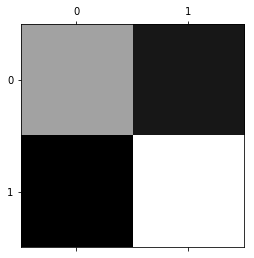

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
ypred = cross_val_predict(svm_clf, X, y, cv=5)
print(classification_report(y, ypred, digits=10))
conf_mx = confusion_matrix(y, ypred)
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

## ROC

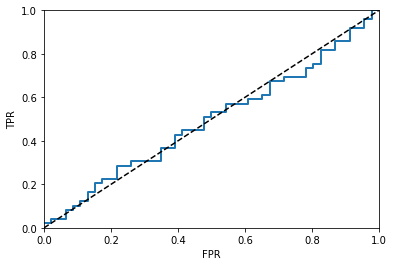

In [40]:
from sklearn.metrics import roc_curve
yw_scores = cross_val_predict(svm_clfw, Xw, yw, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(yw, yw_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr)
plt.show()

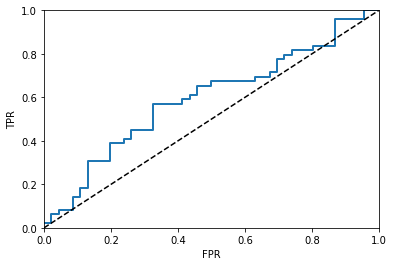

In [41]:
from sklearn.metrics import roc_curve
y_scores = cross_val_predict(svm_clf, X, y, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

plot_roc_curve(fpr, tpr)
plt.show()

## COMPARISON

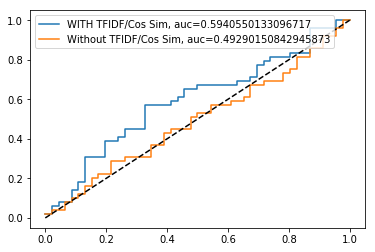

In [48]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

#clear figure
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y, y_scores)
auc = metrics.roc_auc_score( y, y_scores)
plt.plot(fpr,tpr,label="WITH TFIDF/Cos Sim, auc="+repr(auc))


fpr, tpr, thresh = metrics.roc_curve(yw, yw_scores)
auc = metrics.roc_auc_score(yw, yw_scores)
plt.plot(fpr,tpr,label="Without TFIDF/Cos Sim, auc="+repr(auc))

plt.plot([0,1],[0,1],'k--')

plt.legend(loc=0)

In [43]:
metric[:3]
#ambot 

,politician,Anarchism,Antisemitism,Capitalism,Christianity,Communism,Conservatism,Democracy,Fascism,Feminism,...,Liberalism,Marxism,Nationalism,Neo-Nazism,Protestantism,Right-wing politics,Secularism,Socialism,White supremacy,target
0,Jo Bonner (R),0.146722,0.091609,0.180479,0.021633,0.097656,0.031023,0.045220,0.034661,0.043991,...,0.078069,0.117421,0.132514,0.241896,0.013566,0.036427,0.094066,0.072632,0.212062,Republican
1,Martha Roby (R),0.033260,0.042244,0.046237,0.021633,0.071264,0.031023,0.045220,0.034661,0.043991,...,0.046106,0.019858,0.010873,0.053905,0.030753,0.036427,0.051254,0.017983,0.054233,Republican
2,Mike Rogers (R),0.021361,0.015905,0.091868,0.021516,0.067148,0.030784,0.028469,0.034363,0.063251,...,0.079620,0.075533,0.012779,0.015556,0.013617,0.036098,0.007482,0.059669,0.112613,Republican


In [44]:
a

NameError: name 'a' is not defined

In [ ]:
# IMPORTANT METHODS IN PANDAS

# Inserting pandas series at index.
a.insert(0, 'politician', pandas2['x-entity'])

# inserting pandaas series at end of dataframe.
pd2['colname'] = a_pandas_series
